## Exploratory Analysis

### Start with importing required modeles.

In [2]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import cv2 as cv
from copy import deepcopy
import csv
import glob
import os
import sys
from PIL import Image
import re
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

### Define functions to load images and csv files



In [3]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
     
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
     
    return numpyImage, numpyOrigin, numpySpacing


# normalize image pixel value to [0,1]

def normalizePlanes(npzarray):
     
    maxHU = 400.
    minHU = -1000.
 
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray



def readCSV(filename):
    lines = []
    with open(filename, "rb") as f:
        csvreader = csv.reader(f)
        for line in csvreader:
            lines.append(line)
    return lines

### world coordinates to voxel coordinates

Since the coordinates of the candidates are given in World Coordinates, we now need to transform from world coordinates to voxel coordinates. 
<br>
We define now a function to do that. Please note that the transformation below is only valid if there is no rotation component in the transformation matrix. For all CT images in our dataset, there is no rotation component so that this formula can be used. 
<br>
This function takes as inputs:
    - The world coordinates
    - The origin
    - The pixel Spacing
<br>
This function returns:
    - Voxel coordinates (voxelCoord)

In [4]:
def worldToVoxelCoord(worldCoord, origin, spacing):
     
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

### Specify the path where the image (img_path) is
### Specificy the path where the file with the list of candidates is (cand_path)

In [10]:
img_path  = 'C:/Users/chuzh/Desktop/thesis/LUNA/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd'
#img_path = 'C:/Users/chuzh/Desktop/thesis/LUNA/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd'
cand_path = 'C:/Users/chuzh/Desktop/thesis/LUNA/CSVFILES/candidates.csv'
ann_path = 'C:/Users/chuzh/Desktop/thesis/LUNA/CSVFILES/annotations.csv'



### Display sample CT scans


In [ ]:
# load image
numpyImage, numpyOrigin, numpySpacing = load_itk_image(img_path)
# print(numpyImage.shape)
# print(numpyOrigin)
# print(numpySpacing)

print("%s Mb for an (%s, %s, %s) array" %(sys.getsizeof(numpyImage)/1024**2, numpyImage.shape[0] , 
                                             numpyImage.shape[1] , numpyImage.shape[2]))

f, plots = plt.subplots(12, 10, sharex='all', sharey='all', figsize=(20, 24))
for i in range(120):
    plots[i // 10, i % 10].axis('off')
    plots[i // 10, i % 10].imshow(numpyImage[i, :, :], cmap=plt.cm.bone)



# for i in np.arange(40, 50):
#     img = numpyImage[i, :, :]
#     plt.imshow(img, cmap = 'gray')
#     plt.show()



60.5001220703125 Mb for an (121, 512, 512) array


### Create display of Animation

In [64]:
plt.rcParams['animation.ffmpeg_path'] = 'C:/Program Files (x86)/ImageMagick-7.0.7-Q8/ffmpeg'
FFwriter = animation.FFMpegWriter()

def animate(npimage, mp4name, path, xyz = 0):
    # Based on @Zombie's code
    fig = plt.figure()
    if xyz == 0:
        anim = plt.imshow(npimage[0,:,:], cmap=plt.cm.bone)
    elif xyz == 1:
        # too many frames (512), downsampling for wasy view
        npimage = npimage[:, ::4, :]
        anim = plt.imshow(cv.resize(npimage[:,0,:], (512, 512)), cmap='gray')
    else:
        npimage = npimage[:, :, ::4]
        anim = plt.imshow(cv.resize(npimage[:,:,0], (512, 512)), cmap='gray')
    plt.close()
    
    def update(i):
        if xyz == 0:
            anim.set_array(npimage[i,:,:])
        elif xyz == 1:
            anim.set_array(cv.resize(npimage[:,i,:], (512,512)) )
        else:
            anim.set_array(cv.resize(npimage[:,:,i], (512, 512)) )
        return anim,
    
    a = animation.FuncAnimation(fig, update, frames=range(npimage.shape[xyz]), interval=50 , blit=True)
    save_path = path+ '/' + mp4name
    a.save(save_path, writer= FFwriter)
    
animate(numpyImage, 'examplez.mp4', 'C:/Users/chuzh/Desktop/thesis/code/clone')
animate(numpyImage, 'exampley.mp4', 'C:/Users/chuzh/Desktop/thesis/code/clone', xyz = 1)
animate(numpyImage, 'examplex.mp4', 'C:/Users/chuzh/Desktop/thesis/code/clone', xyz = 2)



### Animation from z axis

In [51]:
from IPython.display import HTML
import base64

video = open('C:/Users/chuzh/Desktop/thesis/code/clone/examplez.mp4', "rb").read()
video_encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(video_encoded.decode('ascii')))


### Animation from y axis

In [65]:
video = open('C:/Users/chuzh/Desktop/thesis/code/clone/exampley.mp4', "rb").read()
video_encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(video_encoded.decode('ascii')))

### Animation from x axis

In [66]:
video = open('C:/Users/chuzh/Desktop/thesis/code/clone/examplex.mp4', "rb").read()
video_encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(video_encoded.decode('ascii')))

### Loop through all mhd files in the path and extract number of scans, Coord origin & spacing of each patient 

Every patient has distinct Coord origin & spacing. Important to obtain these info to link the scans to annotations.
<br>


Run this block only the first time (because it's slow) and have the retieved info stored locally as csv file.
<br>
Load csv file next time.


In [124]:

# def extract_img_info(folder_path):   
#     pat_id = []
#     num_img = []
#     origin_x = []
#     origin_y = []
#     origin_z = []
#     spacing_x = []
#     spacing_y = []
#     spacing_z = []
    
#     os.chdir(folder_path)
#     for file in glob.glob("*.mhd"):
#         file_path = folder_path + '/' + file
#         numpyImage, numpyOrigin, numpySpacing = load_itk_image(file_path)
#         pat_id.append(file[0: len(file) - 4])    # filename = id + ".mhd"
#         num_img.append(numpyImage.shape[0])
#         origin_x.append(numpyOrigin[0])
#         origin_y.append(numpyOrigin[1])
#         origin_z.append(numpyOrigin[2])
#         spacing_x.append(numpySpacing[0])
#         spacing_y.append(numpySpacing[1])
#         spacing_z.append(numpySpacing[2])
        
#     df = pd.DataFrame({'id':pat_id, 'img_num':num_img, 'origin_x' : origin_x, 'origin_y' : origin_y, 
#                        'origin_z' : origin_z, 'spacing_x' : spacing_x, 'spacing_y' : spacing_y,
#                       'spacing_z' : spacing_z})
    
#     return df

# # # test function with a small sample of data
# # # test = extract_img_info('C:/Users/chuzh/Desktop/thesis/LUNA/sampleset')
# # # print(test)

# sub0 = extract_img_info('C:/Users/chuzh/Desktop/thesis/LUNA/subset0')
# sub1 = extract_img_info('C:/Users/chuzh/Desktop/thesis/LUNA/subset1')
# sub2 = extract_img_info('C:/Users/chuzh/Desktop/thesis/LUNA/subset2')
# sub3 = extract_img_info('C:/Users/chuzh/Desktop/thesis/LUNA/subset3')
# sub4 = extract_img_info('C:/Users/chuzh/Desktop/thesis/LUNA/subset4')
# sub5 = extract_img_info('C:/Users/chuzh/Desktop/thesis/LUNA/subset5')
# sub6 = extract_img_info('C:/Users/chuzh/Desktop/thesis/LUNA/subset6')
# sub7 = extract_img_info('C:/Users/chuzh/Desktop/thesis/LUNA/subset7')
# sub8 = extract_img_info('C:/Users/chuzh/Desktop/thesis/LUNA/subset8')
# sub9 = extract_img_info('C:/Users/chuzh/Desktop/thesis/LUNA/subset9')

# # concatenate dfs
# img_info = pd.concat([sub0, sub1, sub2, sub3, sub4, sub5, sub6, sub7, sub8, sub9])

# img_info.to_csv('C:/Users/chuzh/Desktop/thesis/img_info.csv')


### Check candidates and nodule annotations

 Join img_info with candidate and annotation tables

In [176]:
img_info = pd.read_csv('C:/Users/chuzh/Desktop/thesis/img_info.csv')

# load candidates and annotations

cands = pd.read_csv(cand_path)
anns = pd.read_csv(ann_path)
cands.columns = ['id', 'x', 'y', 'z', 'class']
anns.columns = ['id', 'x', 'y', 'z', 'diameter']

cands_df = cands.set_index('id').join(img_info.set_index('id'))
anns_df = anns.set_index('id').join(img_info.set_index('id'))

# print(cands.iloc[1, :])
# print(cands_df.iloc[1, :])

# print(anns.iloc[4, :])
# print(anns_df.iloc[4, :])

print(anns_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1186 entries, 1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860 to 1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084993415992563148335
Data columns (total 12 columns):
x             1186 non-null float64
y             1186 non-null float64
z             1186 non-null float64
diameter      1186 non-null float64
Unnamed: 0    1186 non-null int64
img_num       1186 non-null int64
origin_x      1186 non-null float64
origin_y      1186 non-null float64
origin_z      1186 non-null float64
spacing_x     1186 non-null float64
spacing_y     1186 non-null float64
spacing_z     1186 non-null float64
dtypes: float64(10), int64(2)
memory usage: 120.5+ KB
None


### Transform world coordinates to voexl coordinates

1351 class 1 and 549714 class 0


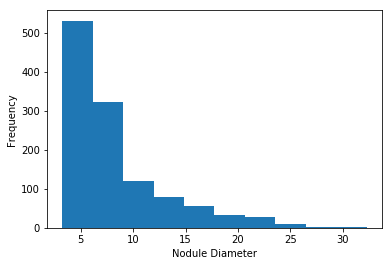

In [175]:
cands_voexlCoord = [ ]
for index, row in cands_df.iterrows():
    cand_worldCoord = np.asarray([float(row['z']) , float(row['y']), float(row['x'])] )
    #convert str to float
    ori = [ float(row['origin_x'] ), float(row['origin_y'] ), float(row['origin_z'] ) ]
    spa = [ float(row['spacing_x']), float(row['spacing_y'] ), float(row['spacing_z'] ) ]
    cand_voexlCoord = worldToVoxelCoord(cand_worldCoord, ori, spa)
    cands_voexlCoord.append(cand_voexlCoord)
    
anns_voexlCoord = [ ]
for index, row in anns_df.iterrows():
    ann_worldCoord = np.asarray([float(row['z']) , float(row['y']), float(row['x'])] )
    #convert str to float
    ori_a = [ float(row['origin_x'] ), float(row['origin_y'] ), float(row['origin_z'] ) ]
    spa_a = [ float(row['spacing_x']), float(row['spacing_y'] ), float(row['spacing_z'] ) ]
    ann_voexlCoord = worldToVoxelCoord(ann_worldCoord, ori_a, spa_a)
    anns_voexlCoord.append(ann_voexlCoord)
    
# print(cands_voexlCoord[0])
# print(anns_voexlCoord[0])

class_values = cands.loc[:, 'class']
class_1_num = sum([ x == 1 for x in  class_values ])
class_0_num = sum([ x == 0 for x in  class_values ])

# check multiple candidates per nodule
print( "%s class 1 and %d class 0"  %(class_1_num, class_0_num))

# check distribution of nodule diameter
plt.hist(anns.loc[: , 'diameter'], 10)
plt.ylabel('Frequency')
plt.xlabel('Nodule Diameter')
plt.show()

### Create bounding box/circle to show nodule annotation

- get an example patient with true nodule
- locate the nodule using x,y,z corrdinates
- extract one scane (closest to the z coord)
- drawing bounding box/circle (Opencv)
- display bounding box/circle on ct scan
<br>
<br>
#### First create a function for this

In [168]:
def visualize_example_nodule_cand(folder_path, annotation = True):
    flag = 0
    os.chdir(folder_path)
    data = anns
    if annotation == False:
        data = cands
    for i in range(len(data)):
        patient = data.iloc[i , 0]
        for file in glob.glob("*.mhd"):
            regex = re.compile(patient)
            match = regex.search(file)
            if match != None:
                flag = 1
                break

        if flag ==1 :
            break
            
#     print(patient)
#     print(file)
#     print(i)

    filepath = folder_path + '/' + file
    patient_imgs, _, _ = load_itk_image(filepath)
    
    if annotation == True:
        patient_coord = anns_voexlCoord[i]
    else:
        patient_coord = cands_voexlCoord[i]
        
    # retrive image closest to nodule on z axis
    img_z = int(round(patient_coord[0], 0))
    img = patient_imgs[img_z, :, :]
    img = normalizePlanes(img)

    # draw bounding box
    img = cv.circle(img, (int(patient_coord[2]), int(patient_coord[1])), 20, (255,0,0), 3)

    cv.imshow('Window', img)
    cv.waitKey(50)
    
    pass
    

### Let's visuliaze some nodules on CT scans

In [169]:
visualize_example_nodule_cand('C:/Users/chuzh/Desktop/thesis/LUNA/subset0', True)

In [170]:
visualize_example_nodule_cand('C:/Users/chuzh/Desktop/thesis/LUNA/subset3', True)

In [171]:
visualize_example_nodule_cand('C:/Users/chuzh/Desktop/thesis/LUNA/subset4', True)

### Then some candidates on CT scans

In [172]:
visualize_example_nodule_cand('C:/Users/chuzh/Desktop/thesis/LUNA/subset2', False)

In [173]:
visualize_example_nodule_cand('C:/Users/chuzh/Desktop/thesis/LUNA/subset8', False)

## Kill image window

In [163]:
cv.destroyAllWindows()
cv.waitKey(1)

-1